# Typical Set Initialization

Stan's MCMC algorithm warms up with an initial fast adaptation interval with default length of 75 warmup iterations.  In these first 75 iterations, "the chain is allowed to converge towards the typical set", see [Stan documentation, Section Automatic Parameter Tuning](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html#automatic-parameter-tuning).  This notebook proposes a new initialization scheme which uses on average fewer gradient evaluations within 75 warmup iterations to move nearly the same distance toward the typical set.

During the 75 warm up iterations, Stan's dynamic HMC leapfrogs through phase space, numerically integrating a system of Hamiltonian equations and then selects a new point ensuring detailed balance holds.  The leapfrog steps ensure progress toward the typical set, while preserving detailed balance provides some sort of asymptotic guarantee that the bias of these initial points will be negligible in approximating expectation values if sufficiently many more samples are drawn.  Since these warmup iterations are commonly thrown away, there's an argument against spending the computational resources to preserve detailed balance.

In the most common use case of Stan, the initial 75 warmup iterations are to find the typical set, not to provide information about expectation values.  This notebook explores the computational gain, if any, to be had in giving up detailed balance during these initial 75 warmup iterations.

Suppose the parameters $\theta \in \mathbb{R}^D$ are initialized as $\theta_d \sim U_d(-2, 2)$ for $d$ in $1$:$D$.  For the sake of argument, let's assume the initialized parameters are far away from the typical set. In this case, either forward or backward leapfrog steps are better for moving toward the typical set, or both foward and backward leapfrog steps are sufficiently good at moving toward the typical set and the only reason to leapfrog in both directions is to ensure detailed balance.  If the initialized parameters are not far away from the typical set, then we don't want the proposed method to be any worse than what Stan does now.

## Algorithm details

**input**: log_density_gradient fn() for a Stan program, dimension D

**output**: a point in parameter space as close to the typical set as Stan might produce


1. initialize $\theta$ from $U(-2, 2)$ until log_density and gradient are finite
2. initialize step_size
3. for step in 1:75
    * while n_leapfrog < max_leapfrogs # (= 2 ^ 10)
        * n_leapfrog += 1
        * position' = leapfrog(position, momentum)
        * check divergence
        * calculate accept_stat
        * if divergent: break
        * if (step <= 64 and a power of 2) or step % 50 == 0
            * if u_turn: break
    * update step_size
    * if not divergent: position = position'

The initialization procedure evaluated below does not try to maintain detailed balance.  Instead, for each iteration, the proposed initialization procedure leapfrogs through phase space until a u-turn is observed.  The point at which a u-turn is observed 

In [1]:
from cmdstanpy import CmdStanModel
from initialize import initialize # the proposed intialization procedure
from pathlib import Path

import bridgestan as bs
bs.set_bridgestan_path(Path.home() / "bridgestan")

import matplotlib.pyplot as plt
import numpy as np

In [9]:
# model = "earnings-earn_height" # typical set is far away
model = "arma-arma11"
stan_file = Path.home() / "minipdb" / "programs" / model / (model + ".stan")
data_file = Path.home() / "minipdb" / "programs" / model / (model + ".json")

bsm = bs.StanModel(stan_file, data_file)
dim = bsm.param_unc_num()

def ldg(position, gradient):
    ld = -np.inf
    try:
        ld, _ = bsm.log_density_gradient(position, out = gradient)
    except:
        pass
    return ld

/Users/ez/venvs/py3/lib/python3.11/site-packages/bridgestan/model.py:174: RuntimeWarning: The version of the compiled model does not match the version of the Python package. Consider recompiling the model.
  warnings.warn(


In [10]:
M = 100
steps = 75
max_leapfrogs = 2 ** 10
cut_off = 0.01

stan_leapfrogs = np.zeros(M)
new_leapfrogs = np.zeros(M)

stan_params = np.zeros(shape = (M, dim))
new_params = np.zeros(shape = (M, dim))

csm = CmdStanModel(stan_file = stan_file)

for m in range(M):
    rng = np.random.default_rng()
    fit_new = initialize(rng, dim, ldg, 
                         steps = steps, 
                         max_leapfrogs = max_leapfrogs,
                         cut_off = cut_off)
    new_leapfrogs[m] = np.sum(fit_new["number_leapfrogs"])
    new_params[m, :] = fit_new["position"]
    
    fit_stan = csm.sample(data = str(data_file),
                     save_warmup = True,
                     iter_sampling = 0,
                     iter_warmup = 100,
                     chains = 1)
    df_draws = fit_stan.draws_pd(inc_warmup = True)
    stan_leapfrogs[m] = np.sum(df_draws["n_leapfrog__"][:steps])
    l = len(df_draws.columns)
    q = df_draws.iloc[steps, (l - dim):l].values.copy()
    stan_params[m, :] = bsm.param_unconstrain(q)

15:56:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:23 - cmdstanpy - INFO - CmdStan done processing.
15:56:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:23 - cmdstanpy - INFO - CmdStan done processing.


15:56:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:23 - cmdstanpy - INFO - CmdStan done processing.


15:56:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:23 - cmdstanpy - INFO - CmdStan done processing.


15:56:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:23 - cmdstanpy - INFO - CmdStan done processing.


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:24 - cmdstanpy - INFO - CmdStan done processing.
15:56:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:24 - cmdstanpy - INFO - CmdStan done processing.


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:24 - cmdstanpy - INFO - CmdStan done processing.


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:24 - cmdstanpy - INFO - CmdStan done processing.
15:56:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:24 - cmdstanpy - INFO - CmdStan done processing.


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:24 - cmdstanpy - INFO - CmdStan done processing.
15:56:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:56:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.
15:56:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.


15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.


15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.


15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.
15:56:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.
15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.
15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:25 - cmdstanpy - INFO - CmdStan done processing.
15:56:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.
15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.
15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.


15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.


15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.
15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.
15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.


15:56:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:26 - cmdstanpy - INFO - CmdStan done processing.


15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.


15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.
15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.
15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.
15:56:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.


15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.


15:56:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:27 - cmdstanpy - INFO - CmdStan done processing.


15:56:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:28 - cmdstanpy - INFO - CmdStan done processing.


15:56:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:28 - cmdstanpy - INFO - CmdStan done processing.
15:56:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:28 - cmdstanpy - INFO - CmdStan done processing.


15:56:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:29 - cmdstanpy - INFO - CmdStan done processing.
15:56:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:29 - cmdstanpy - INFO - CmdStan done processing.


15:56:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:29 - cmdstanpy - INFO - CmdStan done processing.
15:56:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:29 - cmdstanpy - INFO - CmdStan done processing.
15:56:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.
15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.


15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.


15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.
15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.
15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.
15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.
15:56:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:30 - cmdstanpy - INFO - CmdStan done processing.
15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.


15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.


15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.
15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.
15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.
15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.
15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:31 - cmdstanpy - INFO - CmdStan done processing.


15:56:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.


15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:32 - cmdstanpy - INFO - CmdStan done processing.
15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.
15:56:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.
15:56:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.


15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.
15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.
15:56:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.
15:56:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:33 - cmdstanpy - INFO - CmdStan done processing.


15:56:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:34 - cmdstanpy - INFO - CmdStan done processing.
15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.
15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.
15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.
15:56:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.


15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.


15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.
15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.
15:56:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:35 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/ez/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:36 - cmdstanpy - INFO - CmdStan done processing.
15:56:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:37 - cmdstanpy - INFO - CmdStan done processing.
15:56:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:37 - cmdstanpy - INFO - CmdStan done processing.


15:56:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

15:56:37 - cmdstanpy - INFO - CmdStan done processing.


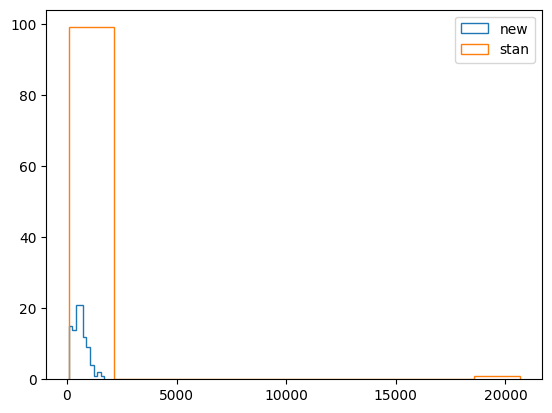

In [11]:
plt.hist(new_leapfrogs, histtype = "step", label = "new")
plt.hist(stan_leapfrogs, histtype = "step", label = "stan")
plt.legend()

In [12]:
mn = np.mean(new_leapfrogs)
ms = np.mean(stan_leapfrogs)
print(f"ratio of mean new_leapfrogs to mean stan_leapfrogs: {mn / ms}")

vn = np.var(new_leapfrogs)
vs = np.var(stan_leapfrogs)
print(f"ratio of var new_leapfrogs to var stan_leapfrogs: {vn / vs}")

np.min(new_leapfrogs) / np.min(stan_leapfrogs)
np.max(new_leapfrogs) / np.max(stan_leapfrogs)

z = np.array([-1.96, 1.96])
(mn - ms) + z * np.sqrt((vn + vs) / M)

ratio of mean new_leapfrogs to mean stan_leapfrogs: 0.6717647058823529
ratio of var new_leapfrogs to var stan_leapfrogs: 0.027212556429916136


array([-683.5176014,  119.9376014])

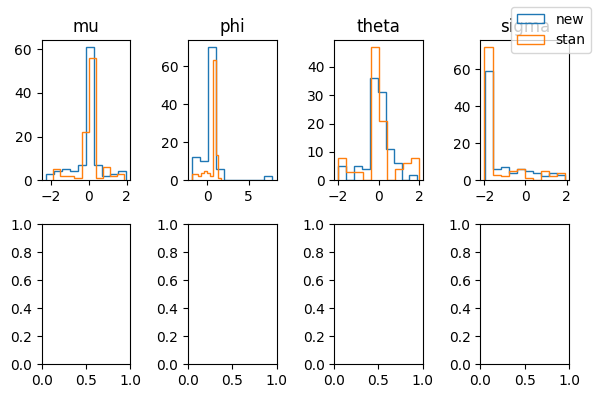

In [13]:
n_cols = 4
n_rows = np.divmod(dim, n_cols)[0] + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize = (6, 4))
md = np.size(np.shape(axs))
param_names = bsm.param_names()

for d in range(dim):
    ir, ic = np.divmod(d, n_cols)
    ax = axs[ic] if md == 1 else axs[ir, ic]
    if d == 0:
        ax.hist(new_params[:, d], histtype = "step", label = "new", )
        ax.hist(stan_params[:, d], histtype = "step", label = "stan")
    else:
        ax.hist(new_params[:, d], histtype = "step")
        ax.hist(stan_params[:, d], histtype = "step")
    ax.title.set_text(param_names[d])
fig.tight_layout()
fig.legend()